In [25]:
import pandas as pd
import ee
import geemap
import imageio
from matplotlib import pyplot as plt
import sys
import warnings
import cv2
warnings.filterwarnings('ignore')

In [27]:
# personal modules
sys.path.append('../src')
from Fishnet import Fishnet

# update files automatically
%load_ext autoreload
%autoreload 2

ee.Initialize(project="jpmorgancapstone")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Generating FishNet

In [13]:
# Create an instance of the Fishnet class
fishnet_creator_example = Fishnet('../Gis/Texas_State_Boundary/State.shp', 4, overlay_method='union', clip=False) # Victor

# Create the fishnet
fishnet_creator_example.create_fishnet()

100%|██████████| 158/158 [00:00<00:00, 547.92it/s]


Generating polygons...
Success. Fishnet created.


,id,geometry
0,0,"POLYGON ((-106.57850 36.43265, -106.57850 36.5..."
1,1,"POLYGON ((-106.51076 36.43265, -106.51076 36.5..."
2,2,"POLYGON ((-106.44303 36.43265, -106.44303 36.5..."
3,3,"POLYGON ((-106.37530 36.43265, -106.37530 36.5..."
4,4,"POLYGON ((-106.30756 36.43265, -106.30756 36.5..."
...,...,...
30647,30647,"POLYGON ((-93.77692 25.79854, -93.77692 25.866..."
30648,30648,"POLYGON ((-93.70919 25.79854, -93.70919 25.866..."
30649,30649,"POLYGON ((-93.64146 25.79854, -93.64146 25.866..."
30650,30650,"POLYGON ((-93.57373 25.79854, -93.57373 25.866..."


In [14]:
fishnet_creator_example.batch(4)  # creates batches of 4miles x 4miles

100%|██████████| 20/20 [00:00<00:00, 3161.46it/s]


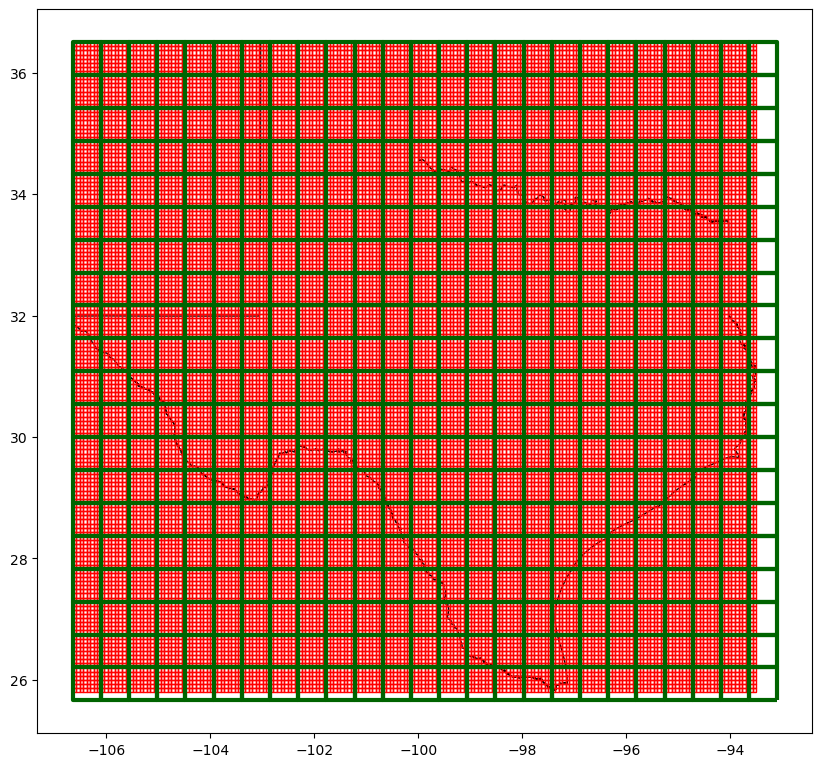

In [15]:
fishnet_creator_example.plot_fishnet()

## Save and Load the fishnet

In [5]:
# this specific fishnet was 0.25miles granular and 4miles edge of each batch.
fishnet_creator.save('../Gis/Fishnet/fishnet_quarter_mile.pkl') # saves the fishnet to a pickle file

In [28]:
# load the object
fishnet_creator = Fishnet.load('../Gis/Fishnet/fishnet_quarter_mile.pkl')

## Filtering

If we only want to focus on specific area of the map (to make the computation quicker), we can use the filtering method below.

In [10]:
region = [-95.799944,29.374853,-95.028636,29.795492]

# Filter the fishnet by the larger bounding box
fishnet_creator.filter_fishnet_by_bbox(region)
fishnet_creator.filtered_fishnet.head(10)

,id,geometry,batch_id
4916194,4916194,"POLYGON ((-95.79622 29.79480, -95.79622 29.799...",19172
4916195,4916195,"POLYGON ((-95.79199 29.79480, -95.79199 29.799...",19172
4916196,4916196,"POLYGON ((-95.78775 29.79480, -95.78775 29.799...",19172
4916197,4916197,"POLYGON ((-95.78352 29.79480, -95.78352 29.799...",19172
4916198,4916198,"POLYGON ((-95.77929 29.79480, -95.77929 29.799...",19172
4916199,4916199,"POLYGON ((-95.77505 29.79480, -95.77505 29.799...",19172
4916200,4916200,"POLYGON ((-95.77082 29.79480, -95.77082 29.799...",19172
4916201,4916201,"POLYGON ((-95.76659 29.79480, -95.76659 29.799...",19172
4916202,4916202,"POLYGON ((-95.76235 29.79480, -95.76235 29.799...",19172
4916203,4916203,"POLYGON ((-95.75812 29.79480, -95.75812 29.799...",19172


In [11]:
fishnet_creator.filtered_batches

,batch_id,geometry
19172,19172,"POLYGON ((-95.74119 29.79480, -95.74119 29.862..."
19173,19173,"POLYGON ((-95.67345 29.79480, -95.67345 29.862..."
19174,19174,"POLYGON ((-95.60572 29.79480, -95.60572 29.862..."
19175,19175,"POLYGON ((-95.53799 29.79480, -95.53799 29.862..."
19176,19176,"POLYGON ((-95.47025 29.79480, -95.47025 29.862..."
...,...,...
20537,20537,"POLYGON ((-95.26706 29.32067, -95.26706 29.388..."
20538,20538,"POLYGON ((-95.19932 29.32067, -95.19932 29.388..."
20539,20539,"POLYGON ((-95.13159 29.32067, -95.13159 29.388..."
20540,20540,"POLYGON ((-95.06386 29.32067, -95.06386 29.388..."


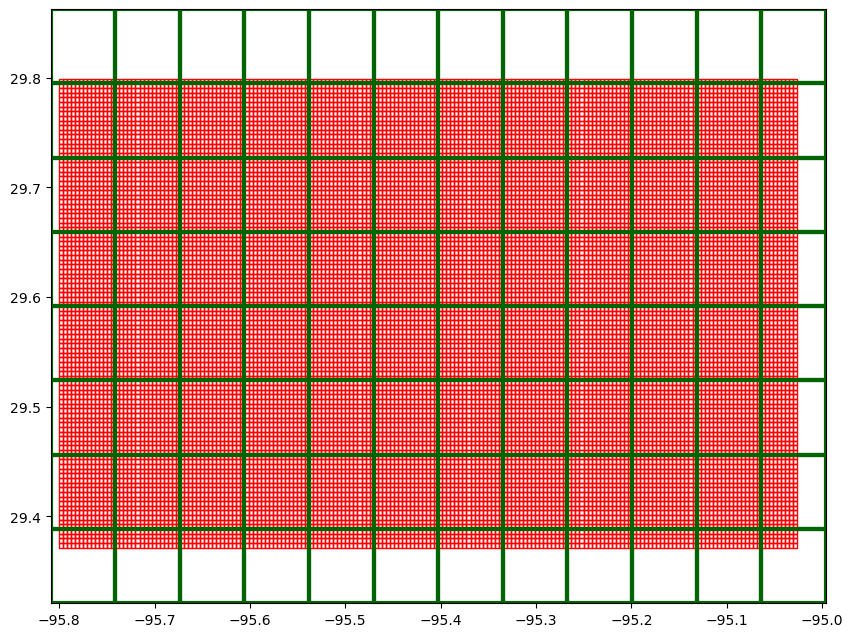

In [12]:
fishnet_creator.plot_filtered_fishnet(zoom=True)

# Now, we need to export the image for each batch. 

In [21]:
from tqdm import tqdm

#Parameters
YEAR = 2016
startDate = f'{YEAR}-05-01'
endDate = f'{YEAR}-09-01'

for i in tqdm(range(len(fishnet_creator.filtered_batches))):
    batch = fishnet_creator.filtered_batches.iloc[i]
    region = ee.Geometry.Rectangle(batch['geometry'].bounds)
    landcover = geemap.dynamic_world(region, startDate, endDate, return_type='visualize')

    ### Save the image
    export_params = {
        'image': landcover,
        'description': f'landcover_batchID_{i}',
        'folder': '/ge_exports/sub_region_export/',  # Google Drive folder name
        'scale': 10,  # Resolution in meters
        'region': region,
        'fileFormat': 'GeoTIFF',
        'maxPixels': 1e10,  # Increase this value if you encounter an error due to the pixel limit
    }

    export_task = ee.batch.Export.image.toDrive(**export_params)
    export_task.start()

100%|██████████| 96/96 [00:44<00:00,  2.16it/s]


# `@TODO: Label Aggregation and Extraction - After Image Extraction`

## Extract images in bulk for the fishnet

Shape: (755, 755, 3)
Data type: uint8
Minimum value: 0
Maximum value: 228


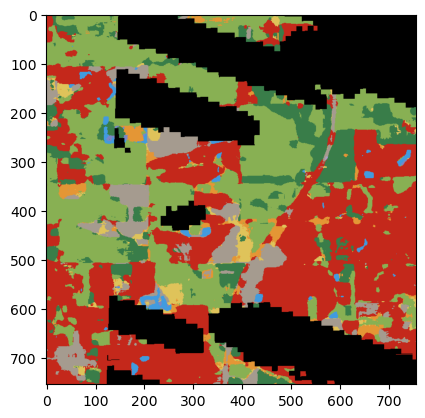

In [29]:
import imageio

image = imageio.imread('../Images/sub-region-exports/landcover_batchID_0.tif') # for Victor

# Print some information about the image
print('Shape:', image.shape)
print('Data type:', image.dtype)
print('Minimum value:', image.min())
print('Maximum value:', image.max())

#plot the image
plt.imshow(image)

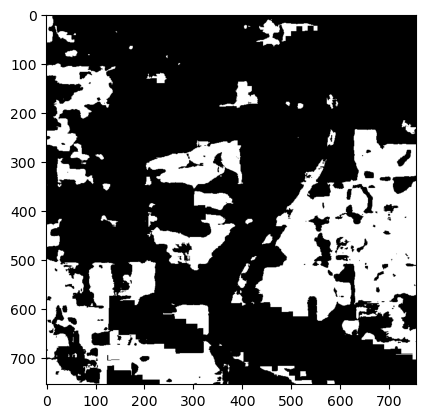

In [30]:
built_pixel = [196, 40, 27] # red
built_image = extract_label(image, built_pixel)
plt.imshow(built_image)

In [31]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import box

def latlong_to_pixel(bbox, region, img_shape):
    """
    Convert lat/long coordinates to pixel coordinates.

    Parameters:
    bbox (tuple): A tuple of (xmin, ymin, xmax, ymax) representing the bounding box.
    region (list): A list of [x1, x2, x3, x4] representing the lat/long coordinates of the 4 image corners.
    img_shape (tuple): A tuple of (height, width) representing the image shape.

    Returns:
    tuple: A tuple of (xmin, ymin, xmax, ymax) representing the pixel coordinates of the bounding box.
    """
    img_height, img_width = img_shape
    x1, x2, x3, x4 = region

    min_lon, max_lon = min(x1, x3), max(x1, x3)
    min_lat, max_lat = min(x2, x4), max(x2, x4)
    xmin, ymin, xmax, ymax = bbox

    # Normalize the bounding box coordinates
    x_min_pixel = int((xmin - min_lon) / (max_lon - min_lon) * img_width)
    x_max_pixel = int((xmax - min_lon) / (max_lon - min_lon) * img_width)
    y_min_pixel = int((1 - (ymax - min_lat) / (max_lat - min_lat)) * img_height)
    y_max_pixel = int((1 - (ymin - min_lat) / (max_lat - min_lat)) * img_height)

    return x_min_pixel, y_min_pixel, x_max_pixel, y_max_pixel

def get_pixel_coordinates(geodataframe):
    """
    Convert lat/long coordinates to pixel coordinates.

    Parameters:
    geodataframe (geopandas.geodataframe.GeoDataFrame): A geodataframe containing the bounding boxes.

    Returns:
    pandas.Series: A pandas series containing the pixel coordinates of the bounding boxes.
    """
    pixel_coordinates = geodataframe['geometry'].apply(lambda x: latlong_to_pixel(x.bounds, region, (img_height, img_width)))
    return pixel_coordinates

from PIL import Image
import numpy as np
import cv2
from tqdm import tqdm

def mean_pixel_values(img_arr, bounding_boxes_gdf):
    """
    Compute the mean pixel value within each bounding box in a geodataframe, for a given image.

    Parameters:
    -----------
    img_arr: numpy.ndarray
        NumPy array of the image.
    bounding_boxes_gdf: geopandas.GeoDataFrame
        Geodataframe of bounding boxes with IDs.

    Returns:
    --------
    list:
        A list of mean pixel values for each bounding box in the geodataframe.
    """
    print("Converting image to PIL object...")
    # Convert the NumPy array to a PIL Image object
    img = Image.fromarray(cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB))

    print("Converting bounding box coordinates to pixel coordinates...")
    # Convert the bounding box coordinates to pixel coordinates
    bounding_boxes_gdf["PixelCoordinates"] = bounding_boxes_gdf["ImageCoordinates"].apply(lambda x: (int(x[0]), int(x[1]), int(x[2]), int(x[3])))

    print("Extracting pixels from each bounding box and computing mean pixel value...")
    # Compute the mean pixel value within each bounding box
    mean_pixel_values = []
    with tqdm(total=len(bounding_boxes_gdf)) as pbar:
        for idx, row in bounding_boxes_gdf.iterrows():
            pixel_box = img.crop(row["PixelCoordinates"])
            mean_pixel_value = np.mean(pixel_box) #int(pd.DataFrame(np.array(pixel_box.getdata()).reshape((-1, 3))).mean().mean())
            mean_pixel_values.append(mean_pixel_value)
            pbar.update(1)

    return mean_pixel_values

def get_unique_colors(image):
    # Reshape the image array into a 2D array of shape (num_pixels, 3)
    reshaped_image = image.reshape(-1, image.shape[-1])

    # Find unique color triples using numpy
    unique_colors = np.unique(reshaped_image, axis=0)

    return unique_colors

unique_colors = get_unique_colors(image)
print(unique_colors)

def extract_label(image, color):
    red_pixels = np.all([
        image[:, :, 0] == color[0],      # Red channel 
        image[:, :, 1] == color[1],      # Green channel
        image[:, :, 2] == color[2]       # Blue channel
    ], axis=0)
    
    extracted_image = np.zeros_like(image)
    extracted_image[red_pixels] = [255,255,255] # Extracted image is black & white
    
    return extracted_image


[[  0   0   0]
 [ 57 125  73]
 [ 65 155 223]
 [122 135 198]
 [136 176  83]
 [165 155 143]
 [179 159 225]
 [196  40  27]
 [223 195  90]
 [228 150  53]]


# `@TODO`

Create a new class:
- takes a batched fishnet as input (of Texas)
- takes a list of images as input (batch_id)
- fishnet geodataframe: add a column "pixel_geometry" with NaNs.
 - for each batch:
    - filters the fishnet on the batch (using the region)
    - convert lat/long geometry into pixel: fill NaNs for that batch in pixel_geometry
    - For each fishnet tile within the batch:
        - extracts the "built" label from the tile
        - compute the mean of the label 
        - stores the mean "built" of that fishnet tile in a new dataframe or in the fishnet dataframe as "UrbanizationRate"
            - batch_id
            - fishnet_id
            - mean_built

In [34]:
fishnet_creator.filtered_fishnet["ImageCoordinates"] = get_pixel_coordinates(fishnet_creator.filtered_fishnet)
fishnet_creator.filtered_fishnet["MeanPixels"] = mean_pixel_values(image, fishnet_creator.filtered_fishnet)

AttributeError: 'Fishnet' object has no attribute 'filtered_fishnet'

In [90]:
filtered_fishnet["MeanPixels"] = mean_pixel_values(image, filtered_fishnet)

Converting image to PIL object...
Converting bounding box coordinates to pixel coordinates...
Extracting pixels from each bounding box and computing mean pixel value...


100%|██████████| 1222/1222 [00:00<00:00, 9031.12it/s]


<Axes: >

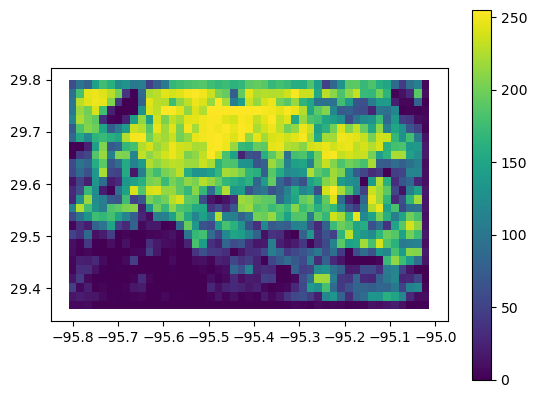

In [91]:
# plot the MeanPixels on the fishnet and map
filtered_fishnet.plot(column='MeanPixels', cmap='viridis', legend=True)

In [92]:
filtered_fishnet

,id,geometry,ImageCoordinates,PixelCoordinates,MeanPixels
162048,162048,"POLYGON ((-95.80892 29.35935, -95.79199 29.359...","(-99, 4667, 88, 4855)","(-99, 4667, 88, 4855)",5.331238
162049,162049,"POLYGON ((-95.79199 29.35935, -95.77505 29.359...","(88, 4667, 277, 4855)","(88, 4667, 277, 4855)",5.741304
162050,162050,"POLYGON ((-95.77505 29.35935, -95.75812 29.359...","(277, 4667, 465, 4855)","(277, 4667, 465, 4855)",7.452892
162051,162051,"POLYGON ((-95.75812 29.35935, -95.74119 29.359...","(465, 4667, 654, 4855)","(465, 4667, 654, 4855)",0.000000
162052,162052,"POLYGON ((-95.74119 29.35935, -95.72425 29.359...","(654, 4667, 842, 4855)","(654, 4667, 842, 4855)",0.656547
...,...,...,...,...,...
181490,181490,"POLYGON ((-95.09772 29.78268, -95.08079 29.782...","(7818, -45, 8007, 142)","(7818, -45, 8007, 142)",87.222222
181491,181491,"POLYGON ((-95.08079 29.78268, -95.06385 29.782...","(8007, -45, 8195, 142)","(8007, -45, 8195, 142)",44.020793
181492,181492,"POLYGON ((-95.06385 29.78268, -95.04692 29.782...","(8195, -45, 8384, 142)","(8195, -45, 8384, 142)",92.575758
181493,181493,"POLYGON ((-95.04692 29.78268, -95.02999 29.782...","(8384, -45, 8572, 142)","(8384, -45, 8572, 142)",110.120890


In [65]:
filtered_fishnet.head(100)

,id,geometry,ImageCoordinates,PixelCoordinates,MeanPixels
162048,162048,"POLYGON ((-95.80892 29.35935, -95.79199 29.359...","(-99, 4667, 88, 4855)","(-99, 4667, 88, 4855)",5
162049,162049,"POLYGON ((-95.79199 29.35935, -95.77505 29.359...","(88, 4667, 277, 4855)","(88, 4667, 277, 4855)",5
162050,162050,"POLYGON ((-95.77505 29.35935, -95.75812 29.359...","(277, 4667, 465, 4855)","(277, 4667, 465, 4855)",5
162051,162051,"POLYGON ((-95.75812 29.35935, -95.74119 29.359...","(465, 4667, 654, 4855)","(465, 4667, 654, 4855)",5
162052,162052,"POLYGON ((-95.74119 29.35935, -95.72425 29.359...","(654, 4667, 842, 4855)","(654, 4667, 842, 4855)",5
...,...,...,...,...,...
163601,163601,"POLYGON ((-95.79199 29.39322, -95.77505 29.393...","(88, 4290, 277, 4478)","(88, 4290, 277, 4478)",5
163602,163602,"POLYGON ((-95.77505 29.39322, -95.75812 29.393...","(277, 4290, 465, 4478)","(277, 4290, 465, 4478)",5
163603,163603,"POLYGON ((-95.75812 29.39322, -95.74119 29.393...","(465, 4290, 654, 4478)","(465, 4290, 654, 4478)",5
163604,163604,"POLYGON ((-95.74119 29.39322, -95.72425 29.393...","(654, 4290, 842, 4478)","(654, 4290, 842, 4478)",5


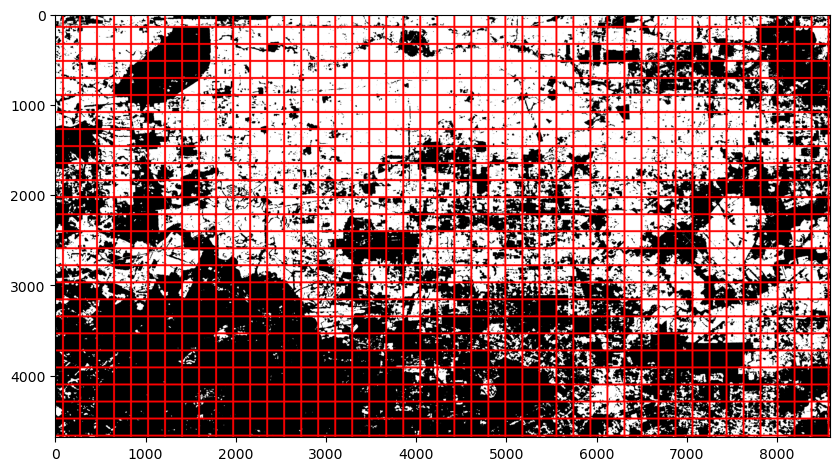

In [61]:

# Load your image
image = cv2.imread('../Images/built_image.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
img_height, img_width, _ = image.shape

# Define the lat/long coordinates of the 4 image corners
region = [-95.799944,29.374853,-95.028636,29.795492]

# Iterate through the bounding boxes in the filtered fishnet
for _, row in filtered_fishnet.iterrows():
    bbox = row['geometry'].bounds
    pixel_bbox = latlong_to_pixel(bbox, region, (img_height, img_width))
    cv2.rectangle(image, (pixel_bbox[0], pixel_bbox[1]), (pixel_bbox[2], pixel_bbox[3]), (255, 0, 0), 20)

# Plot the image with the bounding boxes
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.show()

In [8]:
fishnet_creator = Fishnet('../Gis/Texas_State_Boundary/State.shp', 0.25, overlay_method='union', clip=False) # Victor
fishnet = fishnet_creator.create_fishnet()
fishnet.head()

100%|██████████| 2519/2519 [01:08<00:00, 36.77it/s]


Generating polygons...
Cliping fishinet to boundaries...


In [ ]:
# SAVE FISHNET

# Large image

In [95]:
img_pth1 = '../Images/export2/land_labels_test_export2-0000000000-0000000000.tif'
img_pth2 = '../Images/export2/land_labels_test_export2-0000000000-0000037888.tif'
img_pth3 = '../Images/export2/land_labels_test_export2-0000000000-0000075776.tif'
img_pth4 = '../Images/export2/land_labels_test_export2-0000000000-0000151552.tif'
img_pth5 = '../Images/export2/land_labels_test_export2-0000000000-0000151552.tif'
img_pth6 = '../Images/export2/land_labels_test_export2-0000037888-0000000000.tif'
img_pth7 = '../Images/export2/land_labels_test_export2-0000037888-0000037888.tif'
img_pth8 = '../Images/export2/land_labels_test_export2-0000037888-0000075776.tif'
img_pth9 = '../Images/export2/land_labels_test_export2-0000037888-0000113664.tif'
img_pth10 = '../Images/export2/land_labels_test_export2-0000037888-0000151552.tif'

image = imageio.imread(img_pth2)
# keep only the first band
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
print(image.shape)

(37888, 37888)
